In [100]:
# import packages

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

In [101]:
# import dataset

df = pd.read_csv("../../data/00-raw-data/students_adaptability_level_online_education.csv")

In [102]:
# Overview of the dataset

df.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


In [103]:
# data encoding

cat_features = df.select_dtypes(include=['object']).columns


# Separate target variable and features

Y = df['Adaptivity Level']  #  the target variable
X = df.drop('Adaptivity Level', axis=1) # features

# Label encode binary features
binary_features = [col for col in cat_features if len(df[col].unique()) == 2]

label_encoder = LabelEncoder()
for col in binary_features:
    X[col] = label_encoder.fit_transform(X[col])

# one-hot encoding for other categorical features

categorical_features_one_hot = [col for col in cat_features if len(df[col].unique()) > 2]
categorical_features_one_hot.remove('Adaptivity Level')

X = pd.get_dummies(X, columns=categorical_features_one_hot, drop_first=True)

# encode the target variable
Y_encoded = label_encoder.fit_transform(Y)

X.head(),Y_encoded[:5]


(   Gender  Institution Type  IT Student  Location  Load-shedding  \
 0       0                 1           0         1              1   
 1       1                 1           0         1              0   
 2       1                 0           0         1              1   
 3       1                 1           0         1              1   
 4       1                 1           0         1              1   
 
    Internet Type  Self Lms  Age_11-15  Age_16-20  Age_21-25  ...  \
 0              1         0          0          0          1  ...   
 1              0         1          0          0          1  ...   
 2              1         0          0          1          0  ...   
 3              0         0          1          0          0  ...   
 4              0         0          0          1          0  ...   
 
    Education Level_School  Education Level_University  \
 0                       0                           1   
 1                       0                          

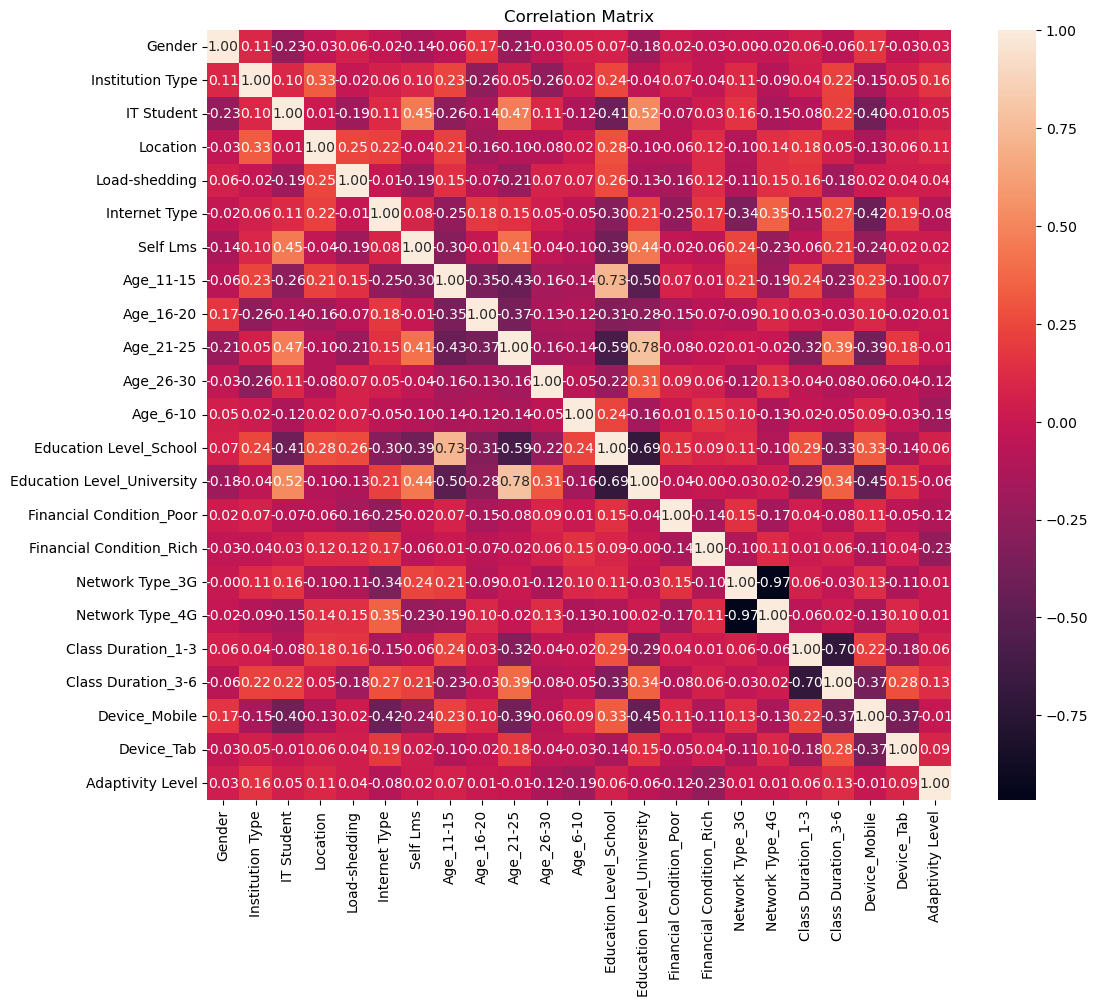

Institution Type              0.162387
Class Duration_3-6            0.126134
Location                      0.107414
Device_Tab                    0.090710
Age_11-15                     0.065929
Education Level_School        0.060147
Class Duration_1-3            0.056353
IT Student                    0.049282
Load-shedding                 0.043611
Gender                        0.033426
Self Lms                      0.022179
Network Type_4G               0.009028
Age_16-20                     0.008839
Network Type_3G               0.005274
Device_Mobile                -0.008298
Age_21-25                    -0.011030
Education Level_University   -0.055119
Internet Type                -0.084276
Financial Condition_Poor     -0.117610
Age_26-30                    -0.121196
Age_6-10                     -0.187684
Financial Condition_Rich     -0.232482
Name: Adaptivity Level, dtype: float64


In [104]:
# Feature selection - part 1

correlation_matrix = pd.concat([X, pd.Series(Y_encoded, name='Adaptivity Level')], axis=1).corr()

correlation_matrix, X.shape


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Extract correlation of features with the target variable 'Adaptivity Level'
correlation_with_target = correlation_matrix['Adaptivity Level'].sort_values(ascending=False)
correlation_with_target = correlation_with_target[correlation_with_target.index != 'Adaptivity Level']
print(correlation_with_target)

In [105]:
# Feature selection - part 2

# Set a threshold for high correlation
threshold = 0.7

multicollinear_pairs = {}

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            if abs(correlation_with_target[colname_i]) < abs(correlation_with_target[colname_j]):
                multicollinear_pairs[colname_i] = colname_j
            else:
                multicollinear_pairs[colname_j] = colname_i

# Remove the identified multicollinear features from the dataset
features_to_remove = list(multicollinear_pairs.keys())
X_reduced = X.drop(columns=features_to_remove)

features_to_remove


['Education Level_School', 'Age_21-25', 'Network Type_3G']

In [106]:
# Export the revised dataframe a new CSV file

Y_encoded_df = pd.DataFrame(Y_encoded, columns=['Adaptivity Level'])

combined_df = pd.concat([X_reduced, Y_encoded_df], axis=1)

New_students_adaptability = combined_df

New_students_adaptability.to_csv('New_students_adaptability.csv')


In [107]:
# naive bayes

data = New_students_adaptability

data.head()

X = data.drop('Adaptivity Level', axis=1)
y = data['Adaptivity Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

GNB = GaussianNB()

# Train the classifier
GNB.fit(X_train, y_train)

# Predict on test data
y_pred = GNB.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

           0       0.49      0.46      0.47        39
           1       0.66      0.71      0.69       154
           2       0.65      0.61      0.63       169

    accuracy                           0.64       362
   macro avg       0.60      0.60      0.60       362
weighted avg       0.64      0.64      0.64       362



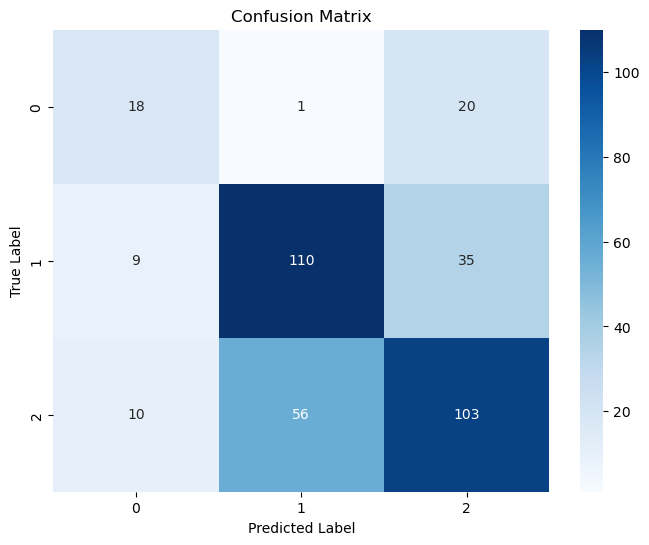

In [108]:
# Visualizations of the results - part1

conf_mat = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(data['Adaptivity Level'])
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels= encoder.classes_, yticklabels= encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



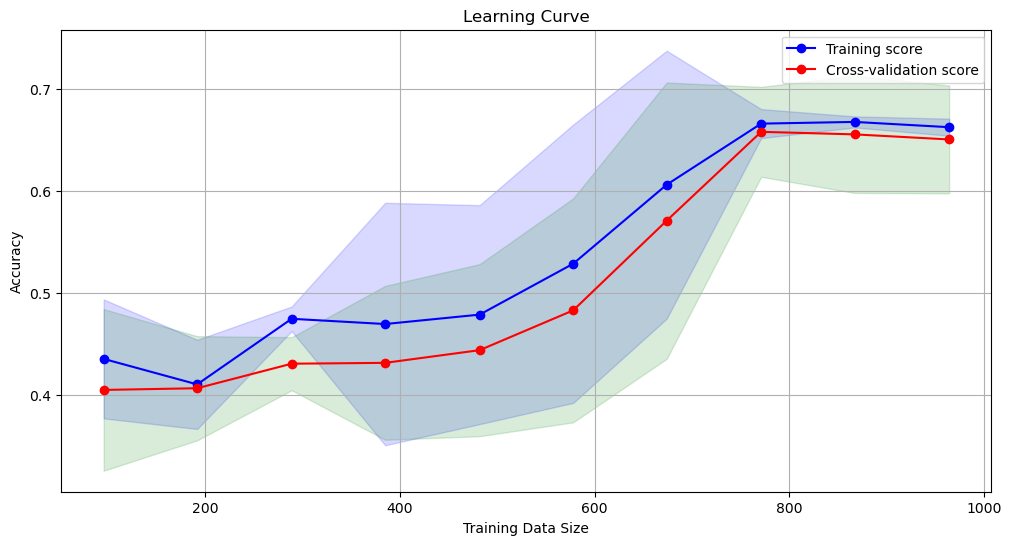

In [109]:
# Visualizations of the results - part2

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=GNB,
    X=X,
    y=y_encoded,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
plt.plot(train_sizes, validation_mean, label='Cross-validation score', color='red', marker='o')
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.15)
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

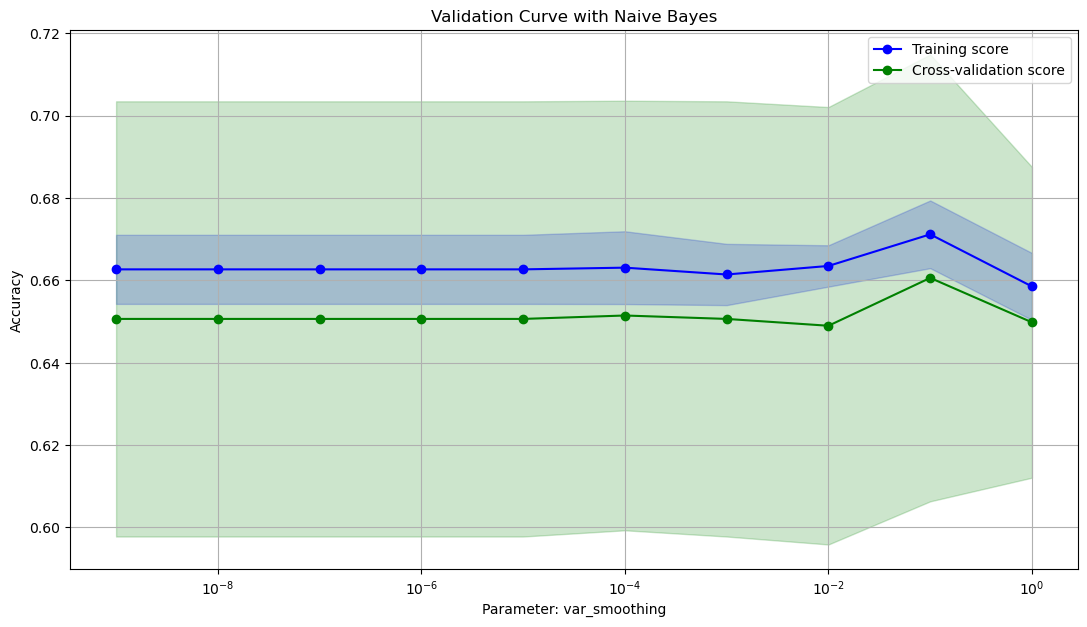

In [112]:
# Visualizations of the results - part3

param_range = np.logspace(-9, 0, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
    GaussianNB(),
    X,
    y_encoded,
    param_name="var_smoothing",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(13, 7))
plt.semilogx(param_range, train_mean, label="Training score", color="blue", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.semilogx(param_range, test_mean, label="Cross-validation score", color="green", marker='o')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)
plt.title('Validation Curve with Naive Bayes')
plt.xlabel('Parameter: var_smoothing')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid(True)
plt.show()